In [154]:
# Imports

import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rnd
import warnings,datetime,os,calendar,csv,time

import tensorflow as tf
import pandas as pd
import seaborn as sns

from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Conv2D,Dropout,BatchNormalization,Input,concatenate,Add,Activation,MaxPooling2D,AveragePooling2D,Flatten
import keras.backend as K

from sklearn import preprocessing as pp

from sklearn.cluster import KMeans,MeanShift
from sklearn.dummy import DummyClassifier,DummyRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import BayesianRidge,Lasso,LinearRegression,SGDClassifier,SGDRegressor
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor,RadiusNeighborsClassifier,RadiusNeighborsRegressor,NearestNeighbors
from sklearn.manifold import Isomap,TSNE
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.svm import LinearSVC,LinearSVR
from sklearn.neural_network import BernoulliRBM,MLPClassifier,MLPRegressor
from sklearn.decomposition import FactorAnalysis,KernelPCA,PCA,MiniBatchSparsePCA,FastICA
from sklearn.preprocessing import CategoricalEncoder,KBinsDiscretizer,LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler

from xgboost import XGBClassifier,XGBRegressor

import pickle,h5py,json

import pandas_datareader as pdr
import urllib
from bs4 import BeautifulSoup
import iexfinance as iex
from iexfinance.stocks import get_historical_data
from scipy.signal import resample,correlate
from scipy import fftpack

warnings.filterwarnings('ignore')
sns.set()
plt.xkcd()

In [2]:
def nanmean(x):
    m = 0
    ctr = 0
    for k in x:
        if np.isnan(k): continue
        m += k
        ctr +=1
    m /= ctr
    return m

In [46]:
def predict_series(xtrain,lookback=5,num_epochs=5):
    
    S = []
    for x in xtrain:
        for k in range(len(x)-lookback):
            S.append(x[k:k+lookback])
    S = np.stack(S,axis=0)

    X = S[:,:-1].reshape(-1,lookback-1,1)
    y = S[:,-1]

    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,shuffle=True)

    lstm0 = LSTM(units=75,activation=tf.nn.relu,return_sequences=False,return_state=False)
    dropout0 = Dropout(rate=0.2)
    dense0 = Dense(units=50,activation=tf.nn.relu)
    dense1 = Dense(units=1,activation=tf.nn.tanh)

    in0 = Input(shape=(Xtrain.shape[1],1,))
    x = lstm0(in0)
    x = dropout0(x)
    x = dense0(x)
    out0 = dense1(x)

    model = Model(in0,out0)
    model.compile(optimizer='adam',loss=tf.losses.mean_squared_error,metrics=['accuracy'])
    model.fit(Xtrain,ytrain,batch_size=3,epochs=num_epochs,validation_split=0.1)
    evalstats = model.evaluate(Xtest,ytest)
    
    return model,evalstats

In [4]:
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2017,1,1)

with open('Documents\stock_symb.txt','r') as f:
    lines = f.readlines()
content = [line.strip() for line in lines]
tickers = [content[i] for i in list(np.random.permutation(np.arange(len(content))))]

ticker_set = tickers[:50]
print_progress = 10

DATA = []
ctr = 0
for ticker in ticker_set:

    if ctr%print_progress==0: print('Processing %d/%d'%(ctr,len(ticker_set)))
    ctr += 1
    try:
        df = get_historical_data(ticker,start=start_date,end=end_date,output_format='pandas')
    except:
        continue
    data = df['open'].values
    DATA.append(data)

Processing 0/50
Processing 10/50
Processing 20/50
Processing 30/50
Processing 40/50


In [5]:
# First project: Fill in NaNs

In [23]:
datalen = [len(data) for data in DATA]
most_common_length = max(set(datalen),key=datalen.count)

xtrain = [data for data in DATA if np.sum(np.isnan(data))==0 and len(data)==most_common_length]
xuse = [data for data in DATA if np.sum(np.isnan(data))!=0]

In [29]:
xtrain_nm = np.stack([xtrain[k]-nanmean(xtrain[k]) for k in range(len(xtrain))],axis=0) 

In [35]:
scaler = MinMaxScaler(feature_range=(-1,1))
xtrain_fit = scaler.fit_transform(xtrain_nm)

In [47]:
df = pd.DataFrame(columns={'lookback','MSE','Accuracy','model'})
df['lookback'] = [2,5,10]

for c_lookback in df['lookback'].values:
    c_model,c_eval = predict_series(xtrain_fit,lookback=c_lookback)
    df.set_value(index=df[df['lookback']==c_lookback].index[0],col='MSE',value=c_eval[0])
    df.set_value(index=df[df['lookback']==c_lookback].index[0],col='Accuracy',value=c_eval[1])
    df.set_value(index=df[df['lookback']==c_lookback].index[0],col='model',value=c_model)

Train on 10843 samples, validate on 1205 samples
Epoch 1/5
10843/10843 [==============================] - 22s 2ms/step - loss: 0.0161 - acc: 0.0662 - val_loss: 0.0076 - val_acc: 0.0656
Epoch 2/5
10843/10843 [==============================] - 16s 2ms/step - loss: 0.0098 - acc: 0.0673 - val_loss: 0.0076 - val_acc: 0.0656
Epoch 3/5
10843/10843 [==============================] - 18s 2ms/step - loss: 0.0094 - acc: 0.0673 - val_loss: 0.0074 - val_acc: 0.0656
Epoch 4/5
10843/10843 [==============================] - 18s 2ms/step - loss: 0.0089 - acc: 0.0672 - val_loss: 0.0076 - val_acc: 0.0656
Epoch 5/5
3012/3012 [==============================] - 0s 85us/step
Train on 10778 samples, validate on 1198 samples
Epoch 1/5
10778/10778 [==============================] - 30s 3ms/step - loss: 0.0140 - acc: 0.0636 - val_loss: 0.0062 - val_acc: 0.0810
Epoch 2/5
10778/10778 [==============================] - 30s 3ms/step - loss: 0.0094 - acc: 0.0645 - val_loss: 0.0071 - val_acc: 0.0810
Epoch 3/5
10778/10

In [79]:
tlid = 10
start = 50

c_lookback = 4

model = df[df['lookback']==c_lookback+1]['model'].values[0]
y_pred = model.predict(xtrain_fit[tlid,start:start+c_lookback].reshape(-1,c_lookback,1))
y_true = xtrain_fit[tlid,start+c_lookback]

print('Real: %f <-> Predicted: %f'%(y_true,y_pred))

Real: -0.412081 <-> Predicted: -0.371061


In [177]:
c_lookback = 4
c_lookforward = 4

S = []
for x in xtrain_nm:
    for k in range(len(x)-(c_lookforward+c_lookback+1)):
        S.append(x[k:k+(c_lookforward+c_lookback+1)])
S = np.stack(S,axis=0)

In [178]:
X = S[:,:c_lookback].reshape(-1,c_lookback,1)
y = S[:,c_lookback].reshape(-1,1)
Z = S[:,c_lookback+1:].reshape(-1,c_lookforward,1)

Zinv = Z[:,range(Z.shape[1]-1,-1,-1)].reshape(-1,c_lookforward,1)

Xtrain,Xtest,ytrain,ytest,Ztrain,Ztest = train_test_split(X,y,Zinv,test_size=0.2,shuffle=True)

In [179]:
lstm0 = LSTM(units=1,activation=tf.nn.tanh,return_sequences=False,return_state=False)

in0 = Input(shape=(c_lookback,1,))
out0 = lstm0(in0)

model_forward = Model(in0,out0)
model_forward.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

model_forward.fit(Xtrain,ytrain,batch_size=3,epochs=5,validation_split=0.2)

Train on 9504 samples, validate on 2376 samples
Epoch 1/5
2733/9504 [=======>......................] - ETA: 27s - loss: 79.7484 - acc: 0.0000e+00

KeyboardInterrupt: 

In [151]:
lstm1 = LSTM(units=1,activation=tf.nn.tanh,return_sequences=False,return_state=False)

in1 = Input(shape=(c_lookforward,1,))
out1 = lstm1(in1)

model_backward = Model(in1,out1)
model_backward.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

model_backward.fit(Ztrain,ytrain,batch_size=3,epochs=5,validation_split=0.2)

Train on 9504 samples, validate on 2376 samples
Epoch 1/5
9504/9504 [==============================] - 22s 2ms/step - loss: 0.0376 - acc: 0.0587 - val_loss: 0.0176 - val_acc: 0.0636
Epoch 2/5
9504/9504 [==============================] - 20s 2ms/step - loss: 0.0121 - acc: 0.0680 - val_loss: 0.0086 - val_acc: 0.0636
Epoch 3/5
9504/9504 [==============================] - 21s 2ms/step - loss: 0.0084 - acc: 0.0681 - val_loss: 0.0079 - val_acc: 0.0636
Epoch 4/5
9504/9504 [==============================] - 22s 2ms/step - loss: 0.0082 - acc: 0.0680 - val_loss: 0.0077 - val_acc: 0.0636
Epoch 5/5
9504/9504 [==============================] - 22s 2ms/step - loss: 0.0081 - acc: 0.0680 - val_loss: 0.0077 - val_acc: 0.0636


In [180]:
in_forward = Input(shape=(c_lookback,1,))
in_backward = Input(shape=(c_lookforward,1,))

lstm_forward = LSTM(units=1,dropout=0,activation=tf.nn.relu,return_sequences=False,return_state=False)
lstm_backward = LSTM(units=1,dropout=0,activation=tf.nn.relu,return_sequences=False,return_state=False)
dense0 = Dense(units=10,activation=tf.nn.relu)
dense1 = Dense(units=1,activation='linear')

x0 = lstm_forward(in_forward)
x1 = lstm_backward(in_backward)

x = concatenate([x0,x1])
x = dense0(x)
out0 = dense1(x)

model_full = Model(inputs=[in_forward,in_backward],outputs=out0)
model_full.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [181]:
model_full.fit([Xtrain,Ztrain],ytrain,batch_size=3,epochs=5,validation_split=0.2)

Train on 9504 samples, validate on 2376 samples
Epoch 1/5
9504/9504 [==============================] - 37s 4ms/step - loss: 41.9197 - acc: 0.0000e+00 - val_loss: 24.2397 - val_acc: 0.0000e+00
Epoch 2/5
9504/9504 [==============================] - 31s 3ms/step - loss: 25.0495 - acc: 0.0000e+00 - val_loss: 13.5637 - val_acc: 0.0000e+00
Epoch 3/5
9504/9504 [==============================] - 30s 3ms/step - loss: 16.6444 - acc: 0.0000e+00 - val_loss: 9.7477 - val_acc: 0.0000e+00
Epoch 4/5
9504/9504 [==============================] - 29s 3ms/step - loss: 11.9401 - acc: 0.0000e+00 - val_loss: 6.3171 - val_acc: 0.0000e+00
Epoch 5/5
9504/9504 [==============================] - 28s 3ms/step - loss: 7.9422 - acc: 0.0000e+00 - val_loss: 4.0811 - val_acc: 0.0000e+00


In [182]:
model_full.evaluate([Xtest,Ztest],ytest)

2970/2970 [==============================] - 0s 108us/step


[5.138991947968801, 0.0]

In [183]:
for testid in range(Xtest.shape[0]):

    xx = Xtest[testid,:].reshape(-1,c_lookback,1)
    zz = Ztest[testid,:].reshape(-1,c_lookforward,1)

    y_real = ytest[testid].reshape(-1,1)
    y_pred = model_full.predict([xx,zz]).reshape(-1,1)

    print('Real:%f <-> Pred:%f  -->  Delta=%f'%(y_real,y_pred,np.abs(y_real-y_pred)))

Real:4.608362 <-> Pred:3.592643  -->  Delta=1.015719
Real:-1.128071 <-> Pred:-0.712018  -->  Delta=0.416054
Real:-2.180364 <-> Pred:-2.291285  -->  Delta=0.110921
Real:-0.572274 <-> Pred:-0.329118  -->  Delta=0.243156
Real:1.509067 <-> Pred:2.021082  -->  Delta=0.512014
Real:-6.558825 <-> Pred:-6.315983  -->  Delta=0.242842
Real:1.991043 <-> Pred:2.742227  -->  Delta=0.751184
Real:10.975966 <-> Pred:8.514783  -->  Delta=2.461183
Real:-4.998308 <-> Pred:-4.705871  -->  Delta=0.292438
Real:-0.022274 <-> Pred:0.089150  -->  Delta=0.111424
Real:-6.164477 <-> Pred:-5.428602  -->  Delta=0.735874
Real:-1.256829 <-> Pred:-1.215462  -->  Delta=0.041367
Real:1.332092 <-> Pred:2.292498  -->  Delta=0.960406
Real:-0.293805 <-> Pred:-0.710887  -->  Delta=0.417082
Real:0.099736 <-> Pred:-0.047366  -->  Delta=0.147102
Real:0.157812 <-> Pred:0.466749  -->  Delta=0.308937
Real:-20.275354 <-> Pred:-23.961571  -->  Delta=3.686217
Real:47.895846 <-> Pred:24.117235  -->  Delta=23.778611
Real:-0.333129 <-> P

Real:-0.231830 <-> Pred:0.031997  -->  Delta=0.263828
Real:-0.544788 <-> Pred:-0.345432  -->  Delta=0.199356
Real:-34.895954 <-> Pred:-32.217434  -->  Delta=2.678520
Real:42.866946 <-> Pred:24.117235  -->  Delta=18.749711
Real:-0.572646 <-> Pred:-0.234165  -->  Delta=0.338480
Real:-6.539534 <-> Pred:-5.753273  -->  Delta=0.786261
Real:2.538945 <-> Pred:3.104342  -->  Delta=0.565398
Real:-0.726729 <-> Pred:-0.813656  -->  Delta=0.086926
Real:-1.983192 <-> Pred:-1.672618  -->  Delta=0.310574
Real:3.858554 <-> Pred:3.596139  -->  Delta=0.262415
Real:4.183571 <-> Pred:3.505054  -->  Delta=0.678517
Real:-1.132708 <-> Pred:-1.060882  -->  Delta=0.071826
Real:1.461229 <-> Pred:2.757910  -->  Delta=1.296682
Real:-5.036786 <-> Pred:-4.068417  -->  Delta=0.968369
Real:-0.070430 <-> Pred:0.213816  -->  Delta=0.284246
Real:4.486566 <-> Pred:3.814896  -->  Delta=0.671670
Real:5.497266 <-> Pred:3.937057  -->  Delta=1.560209
Real:0.006775 <-> Pred:0.270712  -->  Delta=0.263937
Real:-0.926910 <-> Pred

Real:-0.797346 <-> Pred:-0.804268  -->  Delta=0.006922
Real:-0.232274 <-> Pred:-0.102878  -->  Delta=0.129396
Real:2.018014 <-> Pred:3.089228  -->  Delta=1.071214
Real:-0.390229 <-> Pred:0.111308  -->  Delta=0.501537
Real:2.379067 <-> Pred:3.169304  -->  Delta=0.790237
Real:-0.136467 <-> Pred:0.201402  -->  Delta=0.337869
Real:4.019609 <-> Pred:3.386298  -->  Delta=0.633311
Real:0.603170 <-> Pred:0.721651  -->  Delta=0.118481
Real:-4.823334 <-> Pred:-4.023692  -->  Delta=0.799642
Real:0.947136 <-> Pred:2.824405  -->  Delta=1.877269
Real:0.807954 <-> Pred:0.689980  -->  Delta=0.117974
Real:-1.214432 <-> Pred:-1.243477  -->  Delta=0.029045
Real:-4.264457 <-> Pred:-3.605243  -->  Delta=0.659214
Real:0.246375 <-> Pred:0.540044  -->  Delta=0.293669
Real:0.131833 <-> Pred:0.461789  -->  Delta=0.329957
Real:-7.378338 <-> Pred:-6.145143  -->  Delta=1.233196
Real:-2.787757 <-> Pred:-3.310532  -->  Delta=0.522775
Real:0.011514 <-> Pred:0.937728  -->  Delta=0.926214
Real:-0.038030 <-> Pred:0.2446

Real:11.524408 <-> Pred:13.281399  -->  Delta=1.756991
Real:3.044209 <-> Pred:3.464796  -->  Delta=0.420587
Real:28.430846 <-> Pred:24.117235  -->  Delta=4.313611
Real:-1.401055 <-> Pred:-1.746699  -->  Delta=0.345644
Real:-2.079529 <-> Pred:-2.060819  -->  Delta=0.018710
Real:1.081008 <-> Pred:0.912528  -->  Delta=0.168480
Real:0.645407 <-> Pred:1.552776  -->  Delta=0.907369
Real:2.175968 <-> Pred:2.714001  -->  Delta=0.538033
Real:-3.469725 <-> Pred:-2.998769  -->  Delta=0.470956
Real:-0.576555 <-> Pred:-0.039153  -->  Delta=0.537403
Real:-3.603664 <-> Pred:-2.937257  -->  Delta=0.666407
Real:-11.657391 <-> Pred:-11.098889  -->  Delta=0.558502
Real:-0.213446 <-> Pred:0.118637  -->  Delta=0.332083
Real:-0.321357 <-> Pred:0.715944  -->  Delta=1.037301
Real:-0.893088 <-> Pred:-0.916145  -->  Delta=0.023057
Real:-0.204005 <-> Pred:-0.629059  -->  Delta=0.425054
Real:1.798554 <-> Pred:3.269758  -->  Delta=1.471204
Real:-0.257286 <-> Pred:-0.877969  -->  Delta=0.620683
Real:3.195571 <-> Pr

Real:0.712470 <-> Pred:1.122465  -->  Delta=0.409995
Real:-3.477857 <-> Pred:-2.938846  -->  Delta=0.539011
Real:2.222392 <-> Pred:2.940543  -->  Delta=0.718151
Real:1.410395 <-> Pred:0.664665  -->  Delta=0.745730
Real:-9.994264 <-> Pred:-8.346443  -->  Delta=1.647821
Real:-2.104593 <-> Pred:-2.287583  -->  Delta=0.182990
Real:-3.147392 <-> Pred:-2.727404  -->  Delta=0.419988
Real:2.715645 <-> Pred:3.333186  -->  Delta=0.617541
Real:-1.854593 <-> Pred:-2.315628  -->  Delta=0.461035
Real:0.658554 <-> Pred:2.231447  -->  Delta=1.572893
Real:0.681071 <-> Pred:1.050395  -->  Delta=0.369325
Real:-1.312005 <-> Pred:-0.976829  -->  Delta=0.335176
Real:-0.516367 <-> Pred:-0.293773  -->  Delta=0.222594
Real:-0.231230 <-> Pred:-0.055364  -->  Delta=0.175866
Real:0.498133 <-> Pred:0.955955  -->  Delta=0.457822
Real:2.162945 <-> Pred:3.184418  -->  Delta=1.021474
Real:-1.022619 <-> Pred:-1.572568  -->  Delta=0.549949
Real:0.110345 <-> Pred:0.537502  -->  Delta=0.427157
Real:-6.762786 <-> Pred:-5.9

Real:3.349067 <-> Pred:3.275898  -->  Delta=0.073169
Real:1.799067 <-> Pred:2.388710  -->  Delta=0.589643
Real:-4.071610 <-> Pred:-3.741466  -->  Delta=0.330143
Real:-7.783186 <-> Pred:-6.906631  -->  Delta=0.876554
Real:7.708443 <-> Pred:5.624876  -->  Delta=2.083567
Real:0.597114 <-> Pred:0.728421  -->  Delta=0.131307
Real:-1.125257 <-> Pred:-1.084034  -->  Delta=0.041223
Real:-5.212455 <-> Pred:-4.759958  -->  Delta=0.452497
Real:-4.831446 <-> Pred:-4.595709  -->  Delta=0.235737
Real:-0.785229 <-> Pred:-0.454729  -->  Delta=0.330501
Real:4.046895 <-> Pred:3.631514  -->  Delta=0.415381
Real:-2.894593 <-> Pred:-2.477306  -->  Delta=0.417287
Real:12.554008 <-> Pred:12.383207  -->  Delta=0.170801
Real:-0.709930 <-> Pred:-0.643828  -->  Delta=0.066102
Real:-3.886271 <-> Pred:-3.700953  -->  Delta=0.185318
Real:-36.711354 <-> Pred:-33.494102  -->  Delta=3.217251
Real:-5.381344 <-> Pred:-4.694074  -->  Delta=0.687271
Real:-2.717371 <-> Pred:-2.733606  -->  Delta=0.016235
Real:-0.563367 <->

Real:1.013871 <-> Pred:1.431540  -->  Delta=0.417669
Real:-0.480910 <-> Pred:-0.695766  -->  Delta=0.214857
Real:1.071890 <-> Pred:1.462211  -->  Delta=0.390320
Real:-3.020938 <-> Pred:-4.058387  -->  Delta=1.037449
Real:-6.210186 <-> Pred:-4.920863  -->  Delta=1.289323
Real:0.460875 <-> Pred:0.910720  -->  Delta=0.449845
Real:-0.577730 <-> Pred:-0.473083  -->  Delta=0.104647
Real:4.081323 <-> Pred:4.080623  -->  Delta=0.000701
Real:-0.657988 <-> Pred:-0.419247  -->  Delta=0.238741
Real:4.405995 <-> Pred:3.553665  -->  Delta=0.852330
Real:-2.149764 <-> Pred:-2.452813  -->  Delta=0.303049
Real:-1.981446 <-> Pred:-2.135861  -->  Delta=0.154416
Real:-0.222288 <-> Pred:-0.009942  -->  Delta=0.212347
Real:0.655108 <-> Pred:1.373705  -->  Delta=0.718597
Real:-0.085946 <-> Pred:0.305068  -->  Delta=0.391014
Real:-2.228677 <-> Pred:-2.132590  -->  Delta=0.096087
Real:-1.130986 <-> Pred:-1.581321  -->  Delta=0.450336
Real:-2.754346 <-> Pred:-2.528517  -->  Delta=0.225829
Real:-14.015091 <-> Pre

Real:0.080070 <-> Pred:0.513270  -->  Delta=0.433200
Real:2.221645 <-> Pred:3.140474  -->  Delta=0.918829
Real:0.688554 <-> Pred:1.815666  -->  Delta=1.127111
Real:0.439608 <-> Pred:0.759484  -->  Delta=0.319875
Real:-0.116855 <-> Pred:-0.590320  -->  Delta=0.473465
Real:-1.547144 <-> Pred:-1.702758  -->  Delta=0.155614
Real:-0.515164 <-> Pred:-0.206800  -->  Delta=0.308364
Real:-1.317177 <-> Pred:-1.180267  -->  Delta=0.136909
Real:-3.050991 <-> Pred:-2.993047  -->  Delta=0.057944
Real:0.203512 <-> Pred:0.495771  -->  Delta=0.292260
Real:-3.306334 <-> Pred:-2.342968  -->  Delta=0.963366
Real:-2.700933 <-> Pred:-2.684421  -->  Delta=0.016511
Real:0.759067 <-> Pred:0.683503  -->  Delta=0.075564
Real:-1.811964 <-> Pred:2.274342  -->  Delta=4.086305
Real:5.160246 <-> Pred:-2.151033  -->  Delta=7.311280
Real:-13.300891 <-> Pred:-11.847557  -->  Delta=1.453334
Real:1.604392 <-> Pred:2.858862  -->  Delta=1.254471
Real:-5.009891 <-> Pred:-3.974579  -->  Delta=1.035313
Real:-2.902619 <-> Pred:

Real:-11.508877 <-> Pred:-9.995334  -->  Delta=1.513543
Real:-1.022274 <-> Pred:-0.971734  -->  Delta=0.050540
Real:1.258554 <-> Pred:2.374676  -->  Delta=1.116122
Real:0.359475 <-> Pred:0.669437  -->  Delta=0.309962
Real:11.321423 <-> Pred:9.989294  -->  Delta=1.332129
Real:-0.942619 <-> Pred:-0.215409  -->  Delta=0.727210
Real:-0.254567 <-> Pred:-0.002156  -->  Delta=0.252412
Real:0.927726 <-> Pred:1.281682  -->  Delta=0.353956
Real:13.424323 <-> Pred:10.338111  -->  Delta=3.086212
Real:17.365314 <-> Pred:17.595966  -->  Delta=0.230652
Real:-2.916632 <-> Pred:-2.557857  -->  Delta=0.358775
Real:-0.417130 <-> Pred:-0.200112  -->  Delta=0.217018
Real:-0.065467 <-> Pred:0.090318  -->  Delta=0.155786
Real:-8.317964 <-> Pred:-7.884373  -->  Delta=0.433591
Real:-8.743334 <-> Pred:-7.936630  -->  Delta=0.806703
Real:4.562256 <-> Pred:3.455832  -->  Delta=1.106424
Real:3.368554 <-> Pred:3.368431  -->  Delta=0.000124
Real:39.575846 <-> Pred:24.117235  -->  Delta=15.458611
Real:3.072946 <-> Pr

Real:1.411575 <-> Pred:1.968151  -->  Delta=0.556576
Real:-0.460767 <-> Pred:-0.329125  -->  Delta=0.131642
Real:-2.214855 <-> Pred:-2.006233  -->  Delta=0.208623
Real:-9.299664 <-> Pred:-8.326393  -->  Delta=0.973271
Real:-0.074593 <-> Pred:0.126267  -->  Delta=0.200860
Real:5.170256 <-> Pred:3.709432  -->  Delta=1.460824
Real:-0.611992 <-> Pred:-0.625198  -->  Delta=0.013206
Real:16.718775 <-> Pred:16.583906  -->  Delta=0.134869
Real:-3.576071 <-> Pred:-3.384802  -->  Delta=0.191270
Real:2.500675 <-> Pred:3.108225  -->  Delta=0.607550
Real:1.234843 <-> Pred:1.333438  -->  Delta=0.098595
Real:0.317270 <-> Pred:0.849703  -->  Delta=0.532433
Real:1.648554 <-> Pred:2.248157  -->  Delta=0.599602
Real:-0.170267 <-> Pred:-0.062953  -->  Delta=0.107315
Real:0.279023 <-> Pred:-0.249780  -->  Delta=0.528804
Real:-2.294292 <-> Pred:-2.044311  -->  Delta=0.249981
Real:-0.130230 <-> Pred:0.090117  -->  Delta=0.220347
Real:-10.974138 <-> Pred:-9.702506  -->  Delta=1.271632
Real:9.082123 <-> Pred:9

Real:-5.036677 <-> Pred:-4.666773  -->  Delta=0.369904
Real:-1.239177 <-> Pred:-1.055595  -->  Delta=0.183581
Real:0.059067 <-> Pred:1.374918  -->  Delta=1.315850
Real:-6.331177 <-> Pred:-6.477613  -->  Delta=0.146437
Real:0.437554 <-> Pred:0.727761  -->  Delta=0.290207
Real:10.726462 <-> Pred:9.005627  -->  Delta=1.720835
Real:2.283423 <-> Pred:2.421146  -->  Delta=0.137723
Real:0.344212 <-> Pred:0.731744  -->  Delta=0.387533
Real:-1.968744 <-> Pred:-1.662700  -->  Delta=0.306044
Real:-0.097525 <-> Pred:0.109699  -->  Delta=0.207225
Real:-6.747492 <-> Pred:-5.283744  -->  Delta=1.463748
Real:0.168423 <-> Pred:0.324282  -->  Delta=0.155859
Real:-3.067044 <-> Pred:-2.823562  -->  Delta=0.243482
Real:-0.729492 <-> Pred:-1.179448  -->  Delta=0.449956
Real:-1.689110 <-> Pred:-0.927757  -->  Delta=0.761352
Real:-2.525071 <-> Pred:-2.299324  -->  Delta=0.225748
Real:-5.984625 <-> Pred:-4.863844  -->  Delta=1.120781
Real:2.286245 <-> Pred:3.180992  -->  Delta=0.894747
Real:0.142923 <-> Pred:0

Real:-0.006930 <-> Pred:0.035313  -->  Delta=0.042243
Real:-0.314108 <-> Pred:-0.765804  -->  Delta=0.451696
Real:1.728156 <-> Pred:3.165411  -->  Delta=1.437255
Real:9.217214 <-> Pred:6.960164  -->  Delta=2.257050
Real:-0.982274 <-> Pred:-0.936553  -->  Delta=0.045721
Real:-0.263967 <-> Pred:-0.104619  -->  Delta=0.159348
Real:1.098054 <-> Pred:1.221311  -->  Delta=0.123257
Real:-2.506934 <-> Pred:-2.220001  -->  Delta=0.286933
Real:2.559095 <-> Pred:3.291070  -->  Delta=0.731975
Real:-1.373310 <-> Pred:-1.412387  -->  Delta=0.039077
Real:-0.397329 <-> Pred:-0.331350  -->  Delta=0.065979
Real:0.532470 <-> Pred:0.866132  -->  Delta=0.333663
Real:-5.293144 <-> Pred:-4.513448  -->  Delta=0.779696
Real:-6.408491 <-> Pred:-5.679787  -->  Delta=0.728705
Real:-0.523310 <-> Pred:-0.384990  -->  Delta=0.138320
Real:1.182323 <-> Pred:2.371081  -->  Delta=1.188757
Real:8.194190 <-> Pred:6.640279  -->  Delta=1.553912
Real:-4.959644 <-> Pred:-4.535270  -->  Delta=0.424375
Real:-5.031732 <-> Pred:-

Real:-0.203825 <-> Pred:-0.048646  -->  Delta=0.155179
Real:11.307914 <-> Pred:10.477408  -->  Delta=0.830506
Real:-5.542392 <-> Pred:-5.065476  -->  Delta=0.476915
Real:0.097775 <-> Pred:0.380293  -->  Delta=0.282518
Real:-0.473530 <-> Pred:-0.249197  -->  Delta=0.224333
Real:-0.379964 <-> Pred:-2.334212  -->  Delta=1.954248
Real:4.946646 <-> Pred:3.533622  -->  Delta=1.413024
Real:3.441145 <-> Pred:3.279373  -->  Delta=0.161772
Real:-1.554593 <-> Pred:-1.831038  -->  Delta=0.276445
Real:0.450412 <-> Pred:0.511715  -->  Delta=0.061304
Real:-48.283654 <-> Pred:-42.481964  -->  Delta=5.801689
Real:-2.939544 <-> Pred:-2.861601  -->  Delta=0.077944
Real:-0.575877 <-> Pred:-0.551913  -->  Delta=0.023963
Real:0.378554 <-> Pred:2.233395  -->  Delta=1.854841
Real:2.998554 <-> Pred:3.290639  -->  Delta=0.292085
Real:6.615990 <-> Pred:3.917083  -->  Delta=2.698907
Real:2.395056 <-> Pred:3.156226  -->  Delta=0.761170
Real:-0.430910 <-> Pred:-0.374230  -->  Delta=0.056680
Real:1.275492 <-> Pred:1

Real:2.685407 <-> Pred:3.279445  -->  Delta=0.594038
Real:1.422868 <-> Pred:2.121754  -->  Delta=0.698886
Real:-1.022105 <-> Pred:-1.566108  -->  Delta=0.544003
Real:-8.612238 <-> Pred:-8.630930  -->  Delta=0.018692
Real:2.788629 <-> Pred:3.237026  -->  Delta=0.448398
Real:-6.554677 <-> Pred:-5.662384  -->  Delta=0.892293
Real:-0.810492 <-> Pred:-0.129082  -->  Delta=0.681409
Real:-9.897638 <-> Pred:-9.509209  -->  Delta=0.388429
Real:-0.624646 <-> Pred:-0.896996  -->  Delta=0.272350
Real:-1.549364 <-> Pred:-0.506527  -->  Delta=1.042836
Real:-2.051446 <-> Pred:-1.456952  -->  Delta=0.594494
Real:0.087381 <-> Pred:-0.139413  -->  Delta=0.226794
Real:1.165554 <-> Pred:1.737426  -->  Delta=0.571872
Real:0.551890 <-> Pred:1.350352  -->  Delta=0.798462
Real:0.209992 <-> Pred:1.013936  -->  Delta=0.803944
Real:5.892109 <-> Pred:3.634707  -->  Delta=2.257402
Real:-1.700277 <-> Pred:-1.594356  -->  Delta=0.105920
Real:1.397726 <-> Pred:2.067409  -->  Delta=0.669683
Real:6.364009 <-> Pred:4.79

Real:-0.307738 <-> Pred:-0.273679  -->  Delta=0.034060
Real:0.604670 <-> Pred:1.055628  -->  Delta=0.450958
Real:-5.626544 <-> Pred:-4.910254  -->  Delta=0.716291
Real:-1.804593 <-> Pred:-1.172030  -->  Delta=0.632563
Real:-8.552138 <-> Pred:-7.562936  -->  Delta=0.989202
Real:-1.991008 <-> Pred:-2.122285  -->  Delta=0.131276
Real:-2.284777 <-> Pred:-1.374922  -->  Delta=0.909855
Real:-1.260933 <-> Pred:-1.385524  -->  Delta=0.124591
Real:-8.573686 <-> Pred:-8.114832  -->  Delta=0.458854
Real:-2.982619 <-> Pred:2.758787  -->  Delta=5.741406
Real:1.649067 <-> Pred:2.263526  -->  Delta=0.614459
Real:-0.990933 <-> Pred:-1.159487  -->  Delta=0.168554
Real:2.818554 <-> Pred:2.713751  -->  Delta=0.104803
Real:-3.210933 <-> Pred:-2.953218  -->  Delta=0.257715
Real:4.572295 <-> Pred:3.703179  -->  Delta=0.869116
Real:0.422112 <-> Pred:0.834172  -->  Delta=0.412060
Real:-8.972038 <-> Pred:-7.809513  -->  Delta=1.162525
Real:-3.695738 <-> Pred:-3.460396  -->  Delta=0.235343
Real:9.256766 <-> Pre

Real:17.801414 <-> Pred:18.128330  -->  Delta=0.326916
Real:-1.848238 <-> Pred:-2.912299  -->  Delta=1.064061
Real:5.318168 <-> Pred:3.759471  -->  Delta=1.558697
Real:-0.826664 <-> Pred:-0.754892  -->  Delta=0.071772
Real:6.749023 <-> Pred:4.545324  -->  Delta=2.203699
Real:-0.888777 <-> Pred:-0.772454  -->  Delta=0.116323
Real:-6.480138 <-> Pred:-5.937464  -->  Delta=0.542674
Real:-3.100605 <-> Pred:-2.682245  -->  Delta=0.418360
Real:20.743066 <-> Pred:20.457432  -->  Delta=0.285634
Real:-0.969388 <-> Pred:-0.857385  -->  Delta=0.112003
Real:-1.603405 <-> Pred:-1.903589  -->  Delta=0.300185
Real:-9.916238 <-> Pred:-8.582112  -->  Delta=1.334126
Real:0.417912 <-> Pred:0.926723  -->  Delta=0.508811
Real:0.620443 <-> Pred:0.869557  -->  Delta=0.249114
Real:0.258375 <-> Pred:0.601018  -->  Delta=0.342643
Real:16.961862 <-> Pred:16.212885  -->  Delta=0.748977
Real:28.615246 <-> Pred:23.895679  -->  Delta=4.719567
Real:3.291409 <-> Pred:3.775954  -->  Delta=0.484546
Real:0.827514 <-> Pred

In [184]:
T = np.stack(xtrain_nm,axis=0)

In [187]:
tsne = TSNE()
tsne_comp = tsne.fit_transform(T)

In [192]:
dfT = pd.DataFrame(columns={'TSNE0','TSNE1'},data=tsne_comp)

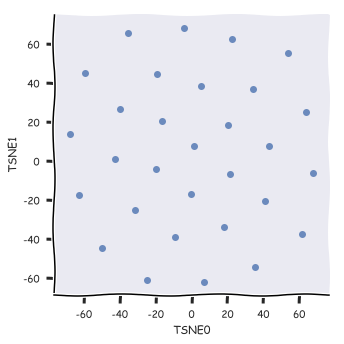

In [194]:
sns.lmplot(x='TSNE0',y='TSNE1',data=dfT,fit_reg=False)

In [204]:
pca = PCA(n_components=2)
pca_comp = pca.fit_transform(T)

dfT['PCA0'] = pca_comp[:,0]
dfT['PCA1'] = pca_comp[:,1]

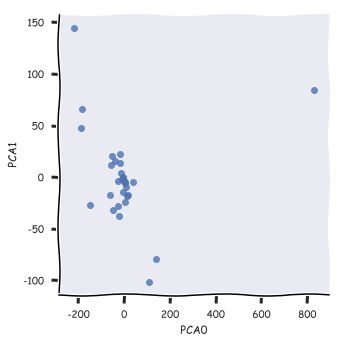

In [205]:
sns.lmplot(x='PCA0',y='PCA1',data=dfT,fit_reg=False)

In [206]:
pca.explained_variance_ratio_

array([0.84360976, 0.05664179])

In [209]:
km = KMeans(n_clusters=5)
km.fit(T)

dfT['KM label'] = km.labels_

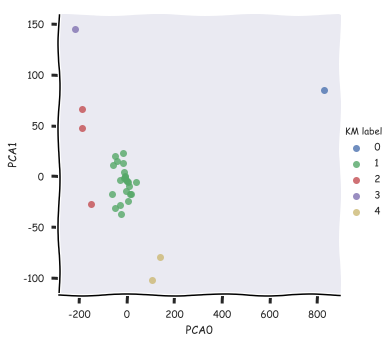

In [210]:
sns.lmplot(x='PCA0',y='PCA1',data=dfT,fit_reg=False,hue='KM label')